# Introduction

Goal of this course: learn how to program GPUs with Julia

Expected experience: minimal familiarity with Julia and GPU programming

Day 1: programming the GPU
- Introduction
- Programming models
- Profiling and optimization

Day 2: advanced topics
- Memory management
- Concurrent computing
- Low-level CUDA APIs

## Why GPU programming in Julia?

*Very briefly*: Julia is

- a **high level** language: easy to write and read
- **designed for performance**: by using careful abstractions, and a JIT compiler

This relatively unique combination makes it a great language for GPU programming, offering both high-level abstractions that are more customizable than in other languages, while also making it possible to write your own kernels and do other low-level work.

## Why CUDA.jl?

Essentially, because it's the most mature and best optimized GPU back-end for Julia.

However, other back-ends are built on top of the same stack, and share a lot of the same infrastructure:

- GPUArrays.jl: vendor neutral array operations
- GPUCompiler.jl: shared infrastructure for kernel compilation
- LLVM.jl, Adapt.jl, etc

As a result, it should be possible to apply much of what you learn here to other back-ends as well. In order of maturity:

- AMDGPU.jl: for [ROCM-supported](https://rocm.docs.amd.com/en/latest/release/gpu_os_support.html) GPUs on Linux
- oneAPI.jl: for most [Intel IGPs and dedicated GPUs](https://github.com/intel/compute-runtime#supported-platforms) on Linux
- Metal.jl: for Apple M-series GPUs on macOS

There's some other experimental back-ends; for more details, see [juliagpu.org](https://juliagpu.org/).

## Set-up

Once connected to the CSCS JupyterLab instance, check-out the course repository at `https://github.com/maleadt/cscs2023` using the Jupyter UI:

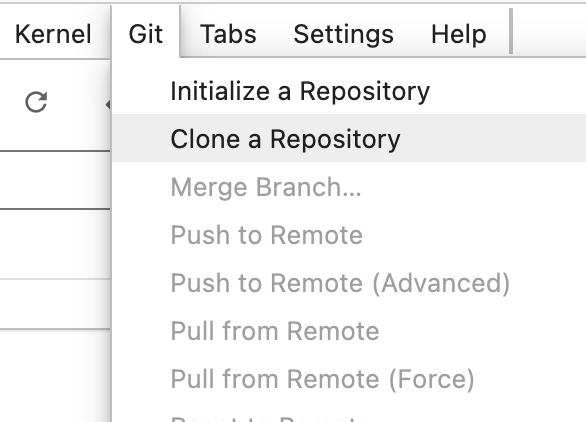

Then, double-click on the `cscs2023` folder, and open the `1-0-introduction.ipynb` notebook to follow along.

<div class="alert alert-block alert-warning">
    <strong>Warning</strong>: Because of how Piz Daint is set-up, you can only access the GPU from a single process. That means you may have to kill previous notebooks before starting a new one.
</div>

CUDA.jl is easy to install, just do `Pkg.add("CUDA")`. For this course, I've provided a pre-configured environment with all relevant packages:

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/cscs2023`
Precompiling project...
  ✓ SIMDTypes
  ✓ RangeArrays
  ✓ RealDot
  ✓ UnPack
  ✓ IndirectArrays
  ✓ CustomUnitRanges
  ✓ ManualMemory
  ✓ StatsAPI
  ✓ CompilerSupportLibraries_jll
  ✓ IterTools
  ✓ TensorCore
  ✓ PkgVersion
  ✓ DocStringExtensions
  ✓ IntervalSets
  ✓ ProgressMeter
  ✓ IfElse
  ✓ Ratios
  ✓ Inflate
  ✓ LazyModules
  ✓ NaNMath
  ✓ IrrationalConstants
  ✓ MappedArrays
  ✓ ComputationalResources
  ✓ CpuId
  ✓ libpng_jll
  ✓ TranscodingStreams
  ✓ SimpleTraits
  ✓ IntelOpenMP_jll
  ✓ SuiteSparse
  ✓ Imath_jll
  ✓ WoodburyMatrices
  ✓ JpegTurbo_jll
  ✓ Zstd_jll
  ✓ FFTW_jll
  ✓ LERC_jll
  ✓ Quaternions
  ✓ Parameters
  ✓ RecipesBase
  ✓ OpenSpecFun_jll
  ✓ IntervalSets → IntervalSetsStatisticsExt
  ✓ Ratios → RatiosFixedPointNumbersExt
  ✓ ThreadingUtilities
  ✓ CoordinateTransformations
  ✓ RegionTrees
  ✓ OffsetArrays
  ✓ Static
  ✓ ArnoldiMethod
  ✓ Distances
  ✓ TranscodingStreams → TestExt
  ✓ LogExpFunctions
  ✓ Graphics
  ✓ MKL_jl

This will take a couple of minutes. Afterwards, try `CUDA.versioninfo()` to see some details about the environment:

In [2]:
using CUDA
CUDA.versioninfo()

CUDA runtime 11.8, artifact installation
CUDA driver 11.4
NVIDIA driver 470.57.2

CUDA libraries: 
- CUBLAS: 11.11.3
- CURAND: 10.3.0
- CUFFT: 10.9.0
- CUSOLVER: 11.4.1
- CUSPARSE: 11.7.5
- CUPTI: 18.0.0
- NVML: 11.0.0+470.57.2

Julia packages: 
- CUDA: 5.1.0
- CUDA_Driver_jll: 0.7.0+0
- CUDA_Runtime_jll: 0.10.0+1

Toolchain:
- Julia: 1.10.0-rc1
- LLVM: 15.0.7

Preferences:
- CUDA_Driver_jll.compat: false

1 device:
  0: Tesla P100-PCIE-16GB (sm_60, 15.897 GiB / 15.899 GiB available)


CUDA.jl bundles many CUDA libraries (from the core toolkit as well as external libraries), making them available as artifacts packaged using BinaryBuilder.jl. Selection of these libraries is tricky, as several compatibility requirements need to be taken into account:

- the local NVIDIA driver has a CUDA Toolkit compatibility level
- starting with CUDA 11.0, the driver is forwards-compatible ("Enhanced Compatibility")
- it may be possible to load a more recent driver library to raise the compatibility level ("Forward Compatibility")
- external libraries (CUDNN, CUTENSOR) may have builds for each CUDA Toolkit

For this course, this should be using CUDA 11.8 from artifacts (instead of the old CUDA 11.0 toolkit provided by the module system).

If you would ever need to disable use of artifacts, you can call `CUDA.set_runtime_version!(version; local_toolkit=true)` where `version` is the version of the local CUDA toolkit. In this configuration, you are responsible for ensuring compatibility between the driver, toolkit, and any libraries! `CUDA.versioninfo()` will then look as follows:

```julia-repl
julia> CUDA.versioninfo()
CUDA toolkit 11.0, local installation
CUDA driver 11.4
NVIDIA driver 470.57.2

...
```

If CUDA.jl doesn't manage to discover your local CUDA installation, you can try launching Julia with the environment variable `JULIA_DEBUG` set to `CUDA_Runtime_Discovery`. This will reveal the locations CUDA.jl searches in for toolkit libraries and binaries:

```
$ JULIA_DEBUG=CUDA_Runtime_Discovery \
  julia -e 'using CUDA'
┌ Debug: Looking for CUDA toolkit via environment variables CUDA_PATH
└ @ CUDA_Runtime_Discovery ~/.julia/packages/CUDA_Runtime_Discovery/VQ7FU/src/CUDA_Runtime_Discovery.jl:294
┌ Debug: Looking for binary ptxas in /opt/cuda
│   all_locations =
│    2-element Vector{String}:
│     "/opt/cuda"
│     "/opt/cuda/bin"
└ @ CUDA_Runtime_Discovery ~/.julia/packages/CUDA_Runtime_Discovery/VQ7FU/src/CUDA_Runtime_Discovery.jl:164
┌ Debug: Found ptxas at /opt/cuda/bin/ptxas
└ @ CUDA_Runtime_Discovery ~/.julia/packages/CUDA_Runtime_Discovery/VQ7FU/src/CUDA_Runtime_Discovery.jl:170
┌ Debug: Looking for binary nvdisasm in /opt/cuda
⋮
```

## A quick tour

CUDA.jl is a large package, containing a lot of functionality:

- wrappers for the CUDA driver, to manage devices, streams, etc
- wrappers for CUDA's libraries, such as cuBLAS, cuFFT, cuRAND, etc
- native kernel programming support: `@cuda`, intrinsics wrappers, a compiler, etc
- high-level functionality that builds on all of the above: `CuArray`, array operations, stdlib integrations, etc

As a quick introduction, I'll use a simple parallel operation that can be used to demonstrate all of the above: AXPY, or $z = \alpha x + y$.

A simple CPU implementation of AXPY using array operations would look as follows:

In [4]:
function axpy!(z, a, x, y)
    z .= a .* x .+ y
end

x = [1, 2]
y = [2, 3]
alpha = 4
z = similar(x)

axpy!(z, alpha, x, y)

2-element Vector{Int64}:
  6
 11

At the highest level of abstraction, we can use exactly the same array operations with CUDA.jl to run this on the GPU:

In [6]:
x = CuArray([1, 2])
y = CuArray([2, 3])
alpha = 4
z = similar(x)

axpy!(z, alpha, x, y)

2-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
  6
 11

This is one of the strenghts of Julia's GPU ecosystem: Generic array operations make it possible to write code that works on all kinds of inputs. Just changing the input type is sufficient to "port" an application to the GPU. Of course, this doesn't always work out perfectly, and sometimes you still need custom operations, but it's a great starting point.

Let's peel back one of the layers, and implement a custom kernel instead of re-using the `broadcast` implementation from CUDA.jl

In [7]:
function axpy_kernel!(z, a, x, y)
    function kernel(z, a, x, y)
        i = threadIdx().x
        if i ≤ length(z)
            @inbounds z[i] = a * x[i] + y[i]
        end
        return
    end

    @cuda threads=length(z) kernel(z, a, x, y)

    return z
end

x = CuArray([1, 2])
y = CuArray([2, 3])
alpha = 4
z = similar(x)
axpy_kernel!(z, alpha, x, y)

2-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
  6
 11

The kernel above is too simple though, as it ignores a crucial limitation: **you cannot launch an unbounded number of threads**, but need to respect the device limit and, if needed, launch multiple blocks. Let's use at most 256 threads, which should work on any GPU:

In [9]:
function axpy_kernel!(z, a, x, y)
    function kernel(z, a, x, y)
        i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
        if i ≤ length(z)
            @inbounds z[i] = a * x[i] + y[i]
        end
        return
    end

    kernel = @cuda launch=false kernel(z, a, x, y)
    threads = min(length(z), 256)
    blocks = cld(length(z), threads)
    kernel(z, a, x, y; threads, blocks)

    return z
end

x = CuArray([1, 2])
y = CuArray([2, 3])
alpha = 4
z = similar(x)
axpy_kernel!(z, alpha, x, y)

2-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
  6
 11

In fact, there's already a good reason to use this `saxpy_kernel!` version, as it's generates slightly better code (requiring fewer registers) than the fully generic `broadcast` implementation:

In [10]:
x = CUDA.rand(Float32, 4096, 4096)
y = CUDA.rand(Float32, 4096, 4096)
z = similar(x)
alpha = rand(Float32)
axpy_kernel!(z, alpha, x, y)   # warm-up
CUDA.@profile trace=true axpy_kernel!(z, alpha, x, y)

Profiler ran for 467.3 µs, capturing 4 events.

Host-side activity: calling CUDA APIs took 49.83 µs (10.66% of the trace)
┌────┬──────────┬──────────┬────────────────┐
│ ID │    Start │     Time │ Name           │
├────┼──────────┼──────────┼────────────────┤
│  2 │ 41.96 µs │ 49.59 µs │ cuLaunchKernel │
└────┴──────────┴──────────┴────────────────┘

Device-side activity: GPU was busy for 370.5 µs (79.29% of the trace)
┌────┬──────────┬──────────┬─────────┬────────┬──────┬─────────────────────────────────────────────────────────────────────────────┐
│ ID │    Start │     Time │ Threads │ Blocks │ Regs │ Name                                                                        │
├────┼──────────┼──────────┼─────────┼────────┼──────┼─────────────────────────────────────────────────────────────────────────────┤
│  2 │ 84.88 µs │ 370.5 µs │     256 │  65536 │    8 │ _Z6kernel13CuDeviceArrayI7Float32Li2ELi1EES0_S_IS0_Li2ELi1EES_IS0_Li2ELi1EE │
└────┴──────────┴──────────┴─────────┴───────

In [12]:
Base.displaysize()

(30, 80)

In [22]:
axpy!(z, alpha, x, y)
CUDA.@profile trace=true axpy!(z, alpha, x, y)

Profiler ran for 1.06 ms, capturing 6 events.

Host-side activity: calling CUDA APIs took 461.58 µs (43.39% of the trace)
┌────┬──────────┬───────────┬────────────────┐
│ ID │    Start │      Time │ Name           │
├────┼──────────┼───────────┼────────────────┤
│  4 │ 52.93 µs │ 458.48 µs │ cuLaunchKernel │
└────┴──────────┴───────────┴────────────────┘

Device-side activity: GPU was busy for 552.42 µs (51.93% of the trace)
┌────┬───────────┬───────────┬─────────┬────────┬──────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ ID │     Start │      Time │ Threads │ Blocks │ Regs │ Name                                                                                                                                                                                         

In [1]:
# work around a Jupyter bug
HTML("""
    <style>
        /*Disable code output line wrapping*/
        div.jp-RenderedText pre {
            white-space: pre;
        }
    </style>""")

Another way to compute AXPY is to use the cuBLAS library, which provides the `cublasXaxpy` functions. We've got those conveniently wrapped in CUDA.jl as `CUBLAS.axpy!`:

In [24]:
x = CuArray([1, 2])
y = CuArray([2, 3])
alpha = 4
CUBLAS.axpy!(length(y), alpha, x, y)

LoadError: MethodError: no method matching axpy!(::Int64, ::Int64, ::CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}, ::CuArray{Int64, 1, CUDA.Mem.DeviceBuffer})

[0mClosest candidates are:
[0m  axpy!(::Integer, ::Number, [91m::StridedCuArray{ComplexF16}[39m, [91m::StridedCuArray{ComplexF16}[39m)
[0m[90m   @[39m [35mCUDA[39m [90m/scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hfp7r/lib/cublas/[39m[90m[4mwrappers.jl:226[24m[39m
[0m  axpy!(::Integer, ::Number, [91m::StridedCuArray{Float16}[39m, [91m::StridedCuArray{Float16}[39m)
[0m[90m   @[39m [35mCUDA[39m [90m/scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hfp7r/lib/cublas/[39m[90m[4mwrappers.jl:221[24m[39m
[0m  axpy!(::Integer, ::Number, [91m::StridedCuArray{ComplexF32}[39m, [91m::StridedCuArray{ComplexF32}[39m)
[0m[90m   @[39m [35mCUDA[39m [90m/scratch/snx3000/julia/tbesard/daint-gpu/packages/CUDA/hfp7r/lib/cublas/[39m[90m[4mwrappers.jl:211[24m[39m
[0m  ...


Well, that immediately demonstrates one of the limitations of NVIDIA's vendor libraries: they only support a handful of types. This is one of the reasons that a native compiler is so valuable, as it allows us to provide both a library-backed implementation and a native implementation.

To test CUBLAS, let's use Float32 inputs:

In [25]:
x = CuArray([1f0, 2f0])
y = CuArray([2f0, 3f0])
alpha = 4f0
CUBLAS.axpy!(length(y), alpha, x, y)

2-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  6.0
 11.0

In [26]:
x = CUDA.rand(Float32, 4096, 4096)
y = CUDA.rand(Float32, 4096, 4096)
alpha = rand(Float32)
CUBLAS.axpy!(length(y), alpha, x, y)   # warm-up
CUDA.@profile trace=true CUBLAS.axpy!(length(y), alpha, x, y)

Profiler ran for 957.01 µs, capturing 6 events.

Host-side activity: calling CUDA APIs took 536.44 µs (56.05% of the trace)
┌────┬───────────┬───────────┬──────────────────┐
│ ID │     Start │      Time │ Name             │
├────┼───────────┼───────────┼──────────────────┤
│  2 │  15.02 µs │   1.67 µs │ cudaGetLastError │
│  3 │  19.79 µs │ 534.06 µs │ cudaLaunchKernel │
│  4 │ 554.32 µs │ 238.42 ns │ cudaGetLastError │
└────┴───────────┴───────────┴──────────────────┘

Device-side activity: GPU was busy for 402.69 µs (42.08% of the trace)
┌────┬───────────┬───────────┬─────────┬────────┬──────┬─────────────────────────────────────────────────────────┐
│ ID │     Start │      Time │ Threads │ Blocks │ Regs │ Name                                                    │
├────┼───────────┼───────────┼─────────┼────────┼──────┼─────────────────────────────────────────────────────────┤
│  3 │ 551.22 µs │ 402.69 µs │     256 │  65536 │   32 │ _Z15axpy_kernel_valIffEv19cublasAxpyParamsValIT_S1_T

Note that despite using the most registers, CUBLAS is likely to be faster than both our naive `axpy!` kernel, and the `broadcast` implementation. However, the benchmark results here are not robust, and we'll look into properly benchmarking GPU code as part of a later codebook.

Now, before moving on to the next notebook, be sure the kernel attached to this notebook, as Piz Daint only allows a single process to use the GPU:

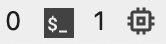